<center>

# Twitter Sentiment Analysis

<center> 

This project is built to determine twitts and classify it into one of three classes: Positive, Negative and Neutral.
I'll build this aplying RNN 
using NLTK----------Tensorflow

<center>

## Importation 

In [1]:
import numpy as np
import pandas as pd 
import os 
import sklearn 
import tensorflow 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import wordcloud
import nltk 
import tensorflow as tf 
import zipfile
import random
import re
import itertools
import spacy
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud



<center>

### Data

In [2]:
archive_path='archive (1).zip'
with zipfile.ZipFile(archive_path,'r') as zip_ref:
    zip_ref.extractall('data.csv')

In [3]:
columns_name=["k","source","feeling","sentence"]
train_df=pd.read_csv('data/twitter_training.csv',names=columns_name)
train_df.drop(labels="k",axis=1,inplace=True)
print( f'this a csv file consist from {train_df.shape}\nincluding these data types\n{train_df.dtypes}')

this a csv file consist from (74682, 3)
including these data types
source      object
feeling     object
sentence    object
dtype: object


In [4]:
train_df.head()

,source,feeling,sentence
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [5]:
train_df.describe(include="all")

,source,feeling,sentence
count,74682,74682,73996
unique,32,4,69491
top,TomClancysRainbowSix,Negative,"At the same time, despite the fact that there ..."
freq,2400,22542,172


In [6]:
train_df.duplicated().sum()

3621

In [7]:

train_df.drop_duplicates(inplace=True)
train_df.dropna(inplace=True)
print(f"our dataframe now have the following shape{train_df.shape}")
train_df.reset_index(drop=True, inplace=True)

our dataframe now have the following shape(70958, 3)


In [8]:
# Cosidering Irrelevant to be Neutral 
train_df["feeling"]=train_df["feeling"].str.replace('Irrelevant','Neutral',regex=True)
land=train_df.source.value_counts()

<center>

### visualization

<center>

#### Distribution

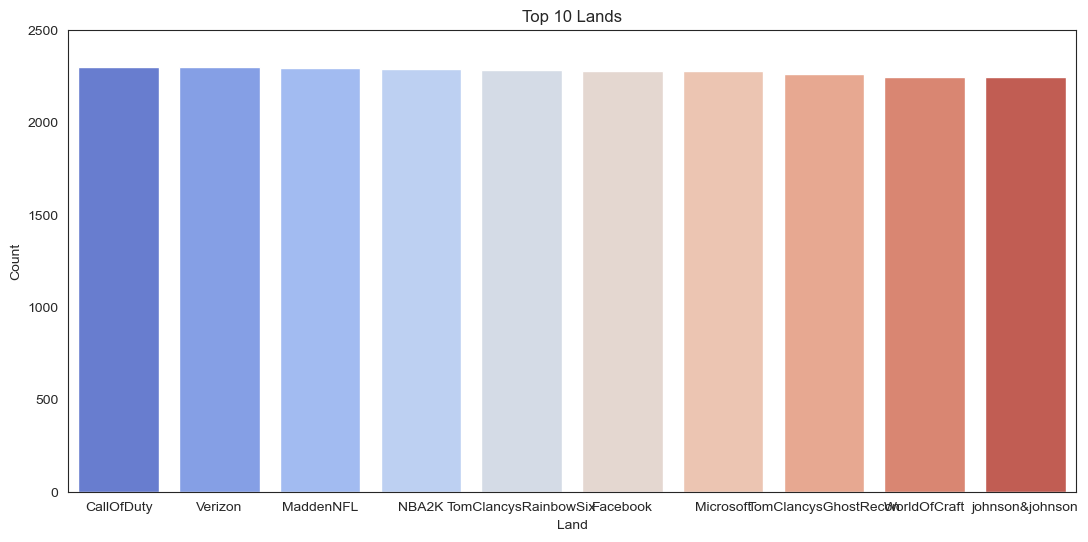

In [9]:
color_palette=['viridis', 'coolwarm', 'cubehelix', 'muted', 'deep', 'rocket', 'pastel',"rocket"]
set_style_options=['whitegrid','white','dark','ticks']
sns.set_style(random.choice(set_style_options))
plt.figure(figsize=(13,6))
bar=sns.barplot(x=land.index[:10],y=land.values[:10],palette=random.choice(color_palette))
plt.title('Top 10 Lands')
plt.xlabel('Land')
plt.ylabel('Count')
plt.ylim(0 , 2500)
plt.show()

<center>

#### Pie chart

In [10]:
moods=train_df.feeling.value_counts()
moods.to_frame().T

feeling,Neutral,Negative,Positive
count,29844,21565,19549


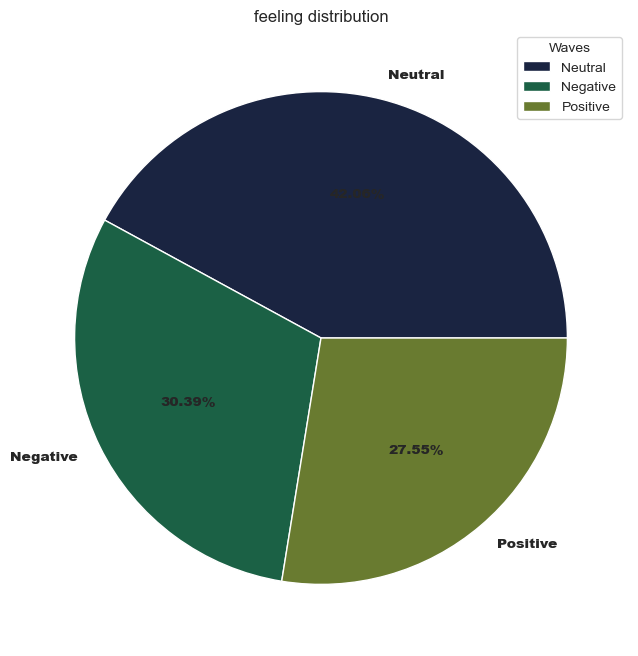

In [11]:
plt.figure(figsize=(8,8))
plt.pie(x=moods.values,labels=moods.keys(),autopct='%1.2f%%',
textprops={"fontsize":10,"fontweight":"black"}
,colors=sns.color_palette(random.choice(color_palette)))
plt.legend(loc='upper right', fontsize=10, title='Waves')
plt.title('feeling distribution')
plt.show()

In [12]:
map_colors=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
pd.crosstab(train_df.source,train_df.feeling).style.background_gradient(subset=['Negative'],cmap=random.choice(map_colors))\
.background_gradient(subset=['Positive'],cmap=random.choice(map_colors))\
.background_gradient(subset=['Neutral'],cmap=random.choice(map_colors))

feeling,Negative,Neutral,Positive
source,,,
Amazon,564,1347,302
ApexLegends,568,1080,598
AssassinsCreed,364,409,1372
Battlefield,439,1241,556
Borderlands,415,816,961
CS-GO,334,1130,705
CallOfDuty,855,1024,425
CallOfDutyBlackopsColdWar,537,880,816
Cyberpunk2077,360,897,889


In [13]:
def emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols
        u"\U0001F680-\U0001F6FF"  # transport and map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"  # dingbats
        u"\U000024C2-\U0001F251"  # various symbols
        "]+",
        flags=re.UNICODE
    )
    clean_text = emoji_pattern.findall( text)
    return clean_text
clean_emojis=[]
for i in range(0,len(train_df)):
    if i==20:
        pass
    else:
        clean_emojis.append(emoji(train_df.sentence[i]))
    single_list = list(itertools.chain.from_iterable(lst for lst in clean_emojis if lst))
print(single_list)



['🙂', '�', '�', '）', '🙂', '�', '■', '，', '。', '�', '：', '・', '�', '�', '：', '。', '�', '●', '🙂', '�', '★', '（', '。', '🙂', '�']


<center>

##### Clean_text

In [14]:
def clean_text(text):
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    return text
random.randint(0,len(train_df.sentence))
tested_text=clean_text(random.choice(train_df['sentence']))
tested_text

'that was great from the xbox. fun and all about the games. lots of new exciting ips too. hyped for xbox series x. i love video games.'

<center>

### Common methods in NLP

<center>

#### part of speech
classify sentences words into (noun-pronoun-verb -adj.................)

In [15]:
nlp=spacy.load('en_core_web_sm')
doc = nlp(tested_text)
for word in doc :
    print(f'{word} => {word.pos_}')

that => PRON
was => AUX
great => ADJ
from => ADP
the => DET
xbox => NOUN
. => PUNCT
fun => NOUN
and => CCONJ
all => PRON
about => ADP
the => DET
games => NOUN
. => PUNCT
lots => NOUN
of => ADP
new => ADJ
exciting => ADJ
ips => NOUN
too => ADV
. => PUNCT
hyped => VERB
for => ADP
xbox => PROPN
series => PROPN
x. => PROPN
i => PRON
love => VERB
video => NOUN
games => NOUN
. => PUNCT


<center>

#### Named Entity Recognition (NER)
Named entities are specific terms that represent real-world objects, such as people, organizations, locations, and dates
![alt text](Blog_Named-Entity-Recognition-–-The-Concept-Types-Applications.webp)


In [16]:
doc=nlp(tested_text)
for entity in doc.ents:
    print(f'{entity}==> {entity.label_}')

xbox==> PRODUCT
xbox series==> EVENT


<center>

#### Chunking 
Converting a text to a smaller peices for having better undrestandin
![alt text](image-asset.jpeg)

In [17]:
doc=nlp(tested_text)
for chunk in doc.noun_chunks:
    print(f"{chunk}==>{chunk.label_}")

that==>NP
the xbox==>NP
fun==>NP
the games==>NP
lots==>NP
new exciting ips==>NP
xbox series==>NP
i==>NP
video games==>NP


<center>

#### Tokenizer
Here's some pattern for RgexpTokenizer

Word Tokenization: r'\b\w+\b'
Matches whole words, including words that may include underscores or numbers.

Sentence Tokenization: r'[^.!?]+[.!?]'
Matches sentences based on sentence-ending punctuation (., !, ?).

Words and Punctuation: r'\b\w+[\w.,?!;:"\'-]*\b'
Matches words and may include punctuation attached to words.

Words and Numbers: r'[a-zA-Z0-9]+'
Matches sequences of letters and numbers.


In [18]:
Tokenizer=RegexpTokenizer(r'\w+')
def  tokenization(text):
   tokenized=Tokenizer.tokenize(text)
   return tokenized
tokenized =tokenization(tested_text)

<center>

#### CountVectorizer
counting the number of occurrences of words

<img src="images.png" alt="alt text" style="width: 900px; height: auto;">

</center>

array([[1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2]],
      dtype=int64)

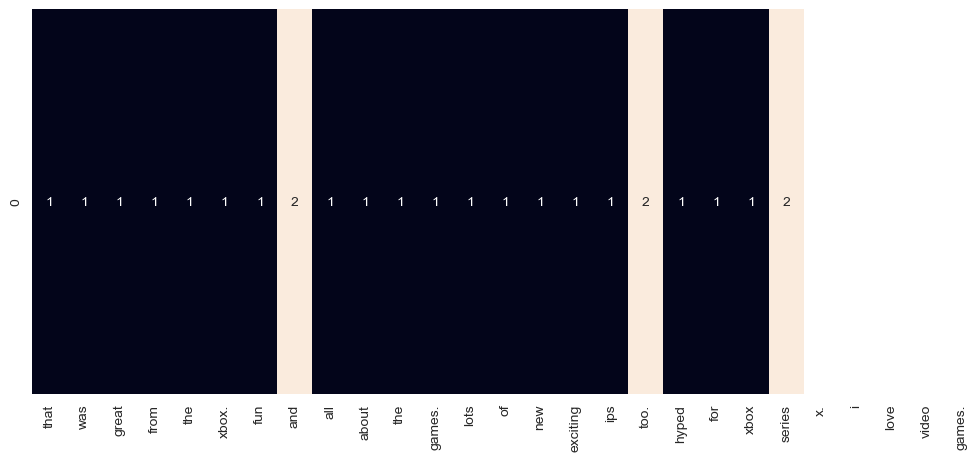

In [19]:
Counter=CountVectorizer()
transform=Counter.fit_transform([tested_text]).toarray()
plt.figure(figsize=(12,5))
sns.heatmap(transform, annot=True,xticklabels=tested_text.split(), 
        cbar=False)
transform

<center>

#### TF_IDF 
It's like Victorization in addition to calculating the percentage for each word
![alt text](1_V9ac4hLVyms79jl65Ym_Bw.png)

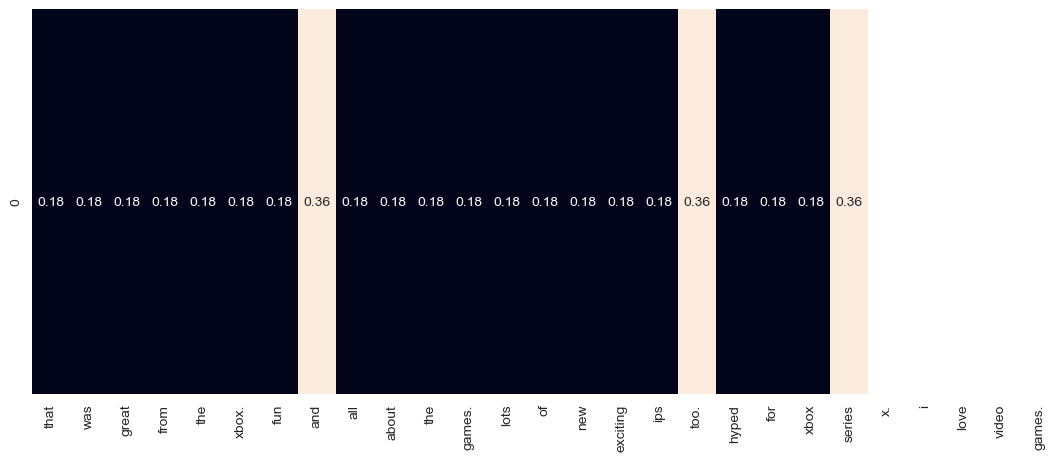

array([[0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.3592106, 0.1796053, 0.1796053, 0.1796053, 0.1796053,
        0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.1796053, 0.3592106,
        0.1796053, 0.1796053, 0.1796053, 0.3592106]])

In [51]:
TF_IDF = TfidfVectorizer()
transform=TF_IDF.fit_transform([tested_text]).toarray()
plt.figure(figsize=(13,5))
sns.heatmap(transform,annot=True,xticklabels=tested_text.split(), 
        cbar=False)
plt.show()
transform

<center> 

#### N-grams
connect the followed words togather  
![alt text](8ARA1.png)

In [21]:
def get_top_m_ngram(corpus, n,m):
    vec = CountVectorizer(ngram_range=(n,n)).fit(corpus)#bag-of-words representation of the text corpus
    #ngram_range=(2, 2) specifies that we want to extract bigrams.
    bag_of_words = vec.transform(corpus)#transforms the corpus into a matrix of token counts.
    sum_words = bag_of_words.sum(axis=0)#calculates the total count of each word (bigram) across all documents.
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]# list contains tuples of bigrams and their corresponding counts.
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)# sorts the bigrams by count in descending order
    return words_freq[:m]

<center>

##### Visualize N_grams for the all sentences

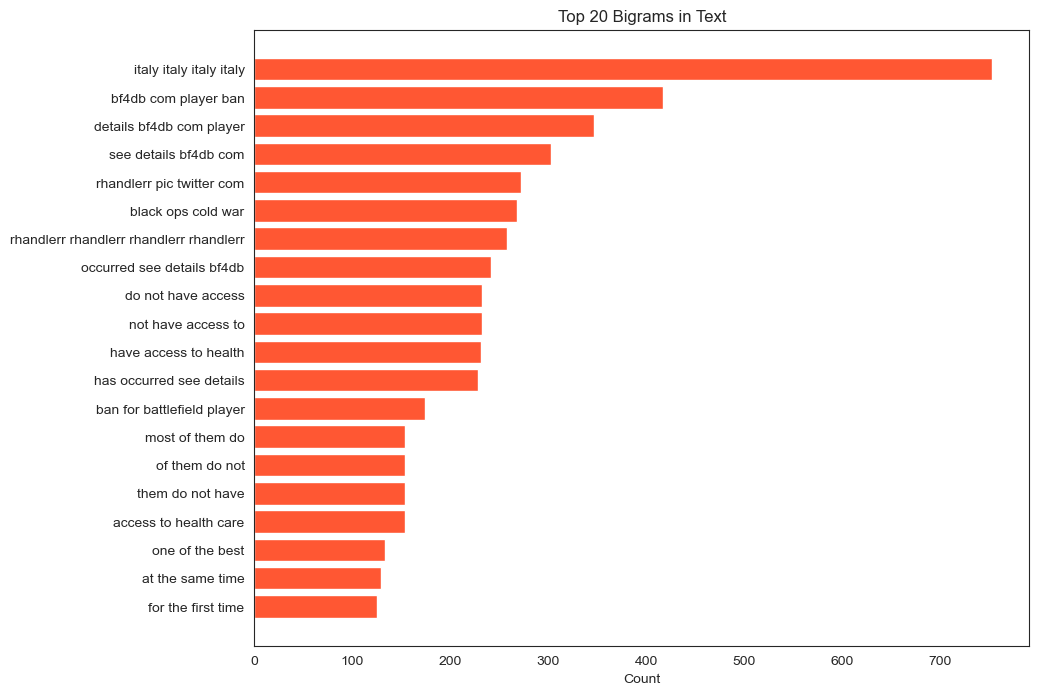

In [22]:
common_ngrams = get_top_m_ngram(train_df['sentence'], 4,20)

df_ngrams = pd.DataFrame(common_ngrams, columns=['bigram', 'count'])#transfer tuples into dataframe with bigram& counts columns 
hex_colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#FFC300', '#DAF7A6', '#C70039', '#581845', '#900C3F', '#FF5733']
plt.figure(figsize=(10, 8))
plt.barh(df_ngrams['bigram'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>

#### Stopwords
Stop words are words which are very common in a language. In many projects , they are deleted because they can not affect and they
can easily increase the volume of texts without any assistance

In [23]:
words=stopwords.words('english')

<center>

#### STemmer
returning words to it's infinity 

![alt text](0_-yUy-dAKeTbPRQuk.png)


In [24]:
stemmer=PorterStemmer()
def stemming(text):

    stemmed_sentence=[stemmer.stem(token) for token in text]
    return stemmed_sentence
stemming(tokenized)

['that',
 'wa',
 'great',
 'from',
 'the',
 'xbox',
 'fun',
 'and',
 'all',
 'about',
 'the',
 'game',
 'lot',
 'of',
 'new',
 'excit',
 'ip',
 'too',
 'hype',
 'for',
 'xbox',
 'seri',
 'x',
 'i',
 'love',
 'video',
 'game']

<center>


<center>

### Application

applying previous methods on our sentences

In [25]:
train_df['sentence']=train_df['sentence'].apply(lambda x : clean_text(x))
train_df['sentence']=train_df['sentence'].apply(lambda x : tokenization(x))

train_df['sentence'].to_frame().head()

,sentence
0,"[i, am, getting, on, borderlands, and, i, will..."
1,"[i, am, coming, to, the, borders, and, i, will..."
2,"[i, am, getting, on, borderlands, and, i, will..."
3,"[i, am, coming, on, borderlands, and, i, will,..."
4,"[i, am, getting, on, borderlands, 2, and, i, w..."


In [26]:
stemmer = PorterStemmer()
stopwords_list = stopwords.words('english')

def setting_sentences(text):
    tokens = text.split()
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token.lower() not in stopwords_list]
    sentence = ' '.join(cleaned_tokens)
    return sentence

In [27]:
train_df['sentence'] = train_df['sentence'].apply(lambda x: setting_sentences(' '.join(x)))


<center> 

### WordCloud

In [28]:
background_colors = [
    'white',
    'black',
    'gray',  
    'red',
    'green',
    'blue',
    'yellow',
    'purple',
    'cyan',
    'magenta',
    'orange',
    'pink',
    'lightblue',
    'darkblue',
    'brown',
    'turquoise',
    'darkgray',  
    'lightgray', 
    'olive'
]

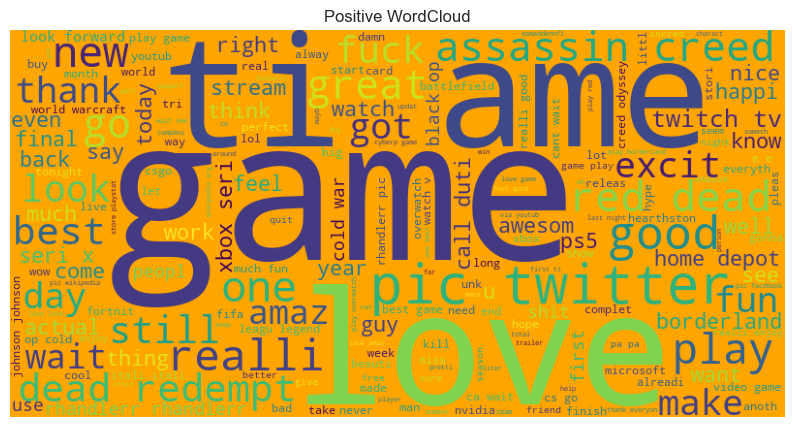

In [29]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Positive WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Positive']['sentence'])
make_word_cloud(all_words)

In [52]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Negative WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Negative']['sentence'])
make_word_cloud(all_words)

ValueError: We need at least 1 word to plot a word cloud, got 0.

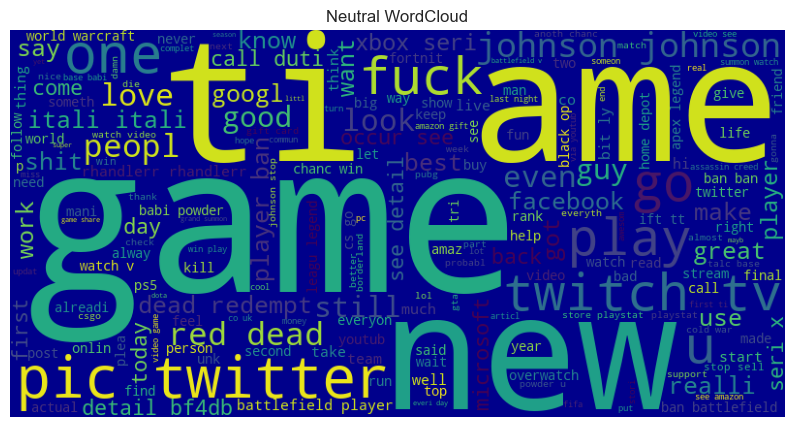

In [31]:
def make_word_cloud(text):
    wordcloud=WordCloud(width=800,height=400,background_color=random.choice(background_colors)).generate(text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('Neutral WordCloud')
    plt.show()
all_words = ' '.join(train_df[train_df['feeling']=='Neutral']['sentence'])
make_word_cloud(all_words)

<center> 

After we git red of the stopwords lets Know what's the most common word in each classification 

<center>

##### Positive

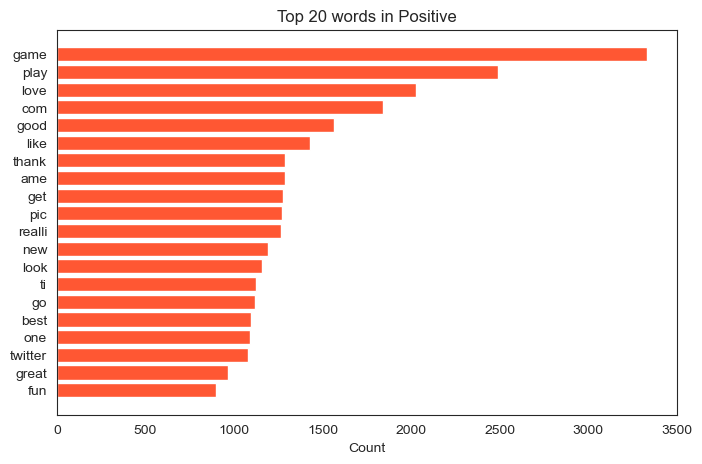

In [32]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Positive']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Positive')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>

##### Negative

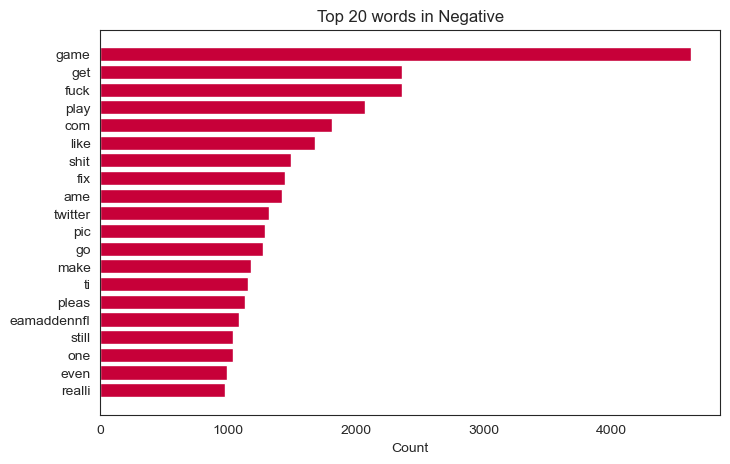

In [33]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Negative']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Negative')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>

##### Neutral

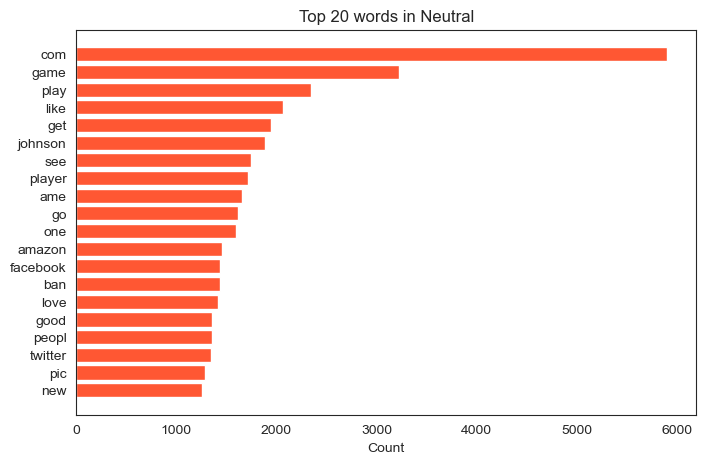

In [34]:
common_ngrams = get_top_m_ngram(train_df[train_df['feeling']=='Neutral']['sentence'], 1,20)
df_ngrams = pd.DataFrame(common_ngrams, columns=['word', 'count'])#transfer tuples into dataframe with bigram& counts columns 

plt.figure(figsize=(8,5 ))
plt.barh(df_ngrams['word'], df_ngrams['count'], color=random.choice(hex_colors))# plot a horizontal bar plot
plt.xlabel('Count')
plt.title('Top 20 words in Neutral')
plt.gca().invert_yaxis() # invert the Y axis 
plt.show()

<center>

##### Additional Step 
when sentence has a huge lens, It's hard for our model to detrmine the classification from it 

In [35]:
lens=[len(tx) for tx in train_df['sentence'].to_list()]
condition=[x for x in lens if x >=200]
print(f'there are {len(condition)} sentences exceed 200 word which harmful to classify ')

there are 784 sentences exceed 200 word which harmful to classify 


<center>
Drop the extra long sentences

In [36]:
condition = train_df['sentence'].apply(lambda x: len(x) >= 200)
indexs=train_df[condition].index
train_df = train_df.drop(index=indexs)
train_df.reset_index(drop=True, inplace=True)

In [37]:
train_df.tail()

,source,feeling,sentence
70169,Nvidia,Positive,realiz window partit mac like 6 year behind nv...
70170,Nvidia,Positive,realiz mac window partit 6 year behind nvidia ...
70171,Nvidia,Positive,realiz window partit mac 6 year behind nvidia ...
70172,Nvidia,Positive,realiz window partit mac like 6 year behind nv...
70173,Nvidia,Positive,like window partit mac like 6 year behind driv...


In [38]:
mapping = {'Positive':1,'Negative':0,'Neutral':2}
train_df['feeling'] = train_df['feeling'].map(mapping)

<center>

## Modeling

<center>

### Importation

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten,Bidirectional

<center>

### splitting our data

In [40]:
x_train,x_test,y_train,y_test=train_test_split(train_df['sentence'],train_df['feeling'],test_size=.1,random_state=42)

In [41]:
y_train=np.array(y_train)
y_test=np.array(y_test)

<center>

tokenize our sentences 

In [42]:
oov_token="<OOV>"
pad='post'
truncating='post'
max_len=35
vocab_size=23225

tokenizer=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer.fit_on_texts(train_df['sentence'])
word_index=tokenizer.word_index
train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded= pad_sequences(train_sequences,padding=pad,truncating=truncating,maxlen=max_len)
test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded= pad_sequences(test_sequences,padding=pad,truncating=truncating,maxlen=max_len)

In [43]:
train_padded.shape

(63156, 35)

<center>

### Embadding 
In the world of applying NLP word embadding has proved to be one of the most powerful, useful to get good performance 

In [44]:
embadding_dim=16

model=Sequential()
model.add(Embedding(vocab_size, embadding_dim, input_length=max_len)) # it's a 2D array with shape         (maxlen,embadding_dim)
model.add(Flatten()) # we can use GlobalAveragePooling1D instead 
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 35, 16)            371600    
                                                                 
 flatten (Flatten)           (None, 560)               0         
                                                                 
 dense (Dense)               (None, 64)                35904     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 409683 (1.56 MB)
Trainable params: 409683 (1.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [46]:
num_epochs=30
history=model.fit(train_padded,
          y_train,
          epochs=num_epochs,
          validation_data=(test_padded,y_test))

Epoch 1/30


1974/1974 [==============================] - 4s 2ms/step - loss: 0.6214 - accuracy: 0.7252 - val_loss: 0.3727 - val_accuracy: 0.8535
Epoch 2/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.2311 - accuracy: 0.9112 - val_loss: 0.2969 - val_accuracy: 0.8860
Epoch 3/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.1407 - accuracy: 0.9445 - val_loss: 0.3045 - val_accuracy: 0.8890
Epoch 4/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.1091 - accuracy: 0.9562 - val_loss: 0.3398 - val_accuracy: 0.8926
Epoch 5/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.0944 - accuracy: 0.9610 - val_loss: 0.3806 - val_accuracy: 0.8843
Epoch 6/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.0835 - accuracy: 0.9650 - val_loss: 0.4016 - val_accuracy: 0.8844
Epoch 7/30
1974/1974 [==============================] - 3s 1ms/step - loss: 0.0755 - accuracy: 0.9675 - val_loss: 0.4475 - val_accurac

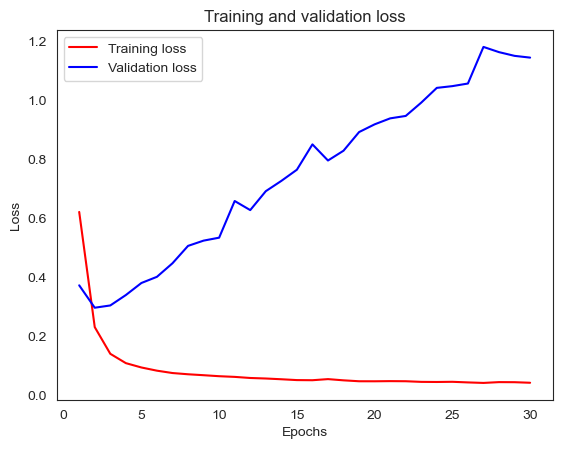

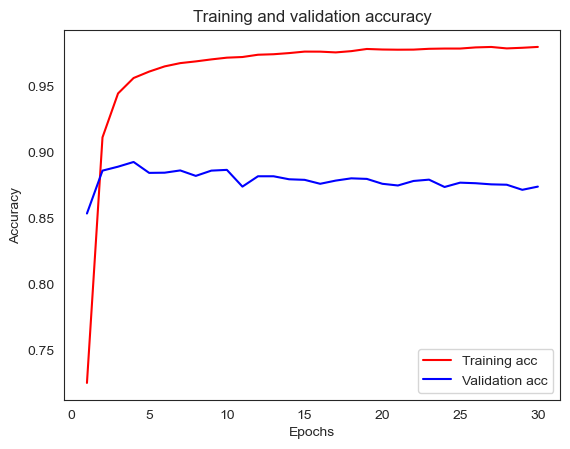

In [48]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<center>

### Biodirectional

In [ ]:
model=Sequential()
model.add(Embedding(vocab_size, embadding_dim, input_length=max_len)) # it's a 2D array with shape         (maxlen,embadding_dim)
model.add(Bio) # we can use GlobalAveragePooling1D instead 
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()



In [191]:
import io

In [200]:
e=model.layers[0]
weights=e.get_weights()[0]

reverse_word_index=tokenizer.index_word
out_v= io.open('vecs.tsv','w',encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1,vocab_size):
    word=reverse_word_index[word_num]
    embeddings=weights[word_num]
    out_m.write(word+'\n')
    out_v.write('\t'.join([str(x) for x in embeddings])+'\n')
out_v.close()
out_m.close()



![alt text](<Screenshot (101).png>)